# Does Diversity Attract Diversity: Business Travellers to U.S. Cities
### Data Engineering Capstone Project

#### Project Summary


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import calendar
from pyspark.sql.functions import udf, col, isnan, when, count, stddev

### Step 1: Scope the Project and Gather Data

#### Scope 
The United States is famous for its diversity, a melting pot or a dream that attracts people from different origins and backgrounds. We always think that diversity is beneficial, yet we don't have that many proofs from an economic perspective, particularly from a city level. This project intends to show some evidence on this regard by aggregating the business travellers to the U.S. and associate their diversity to the characteristics of the city. It thus shows us some insights on whether diversity indeed attracts diversity.

#### Describe and Gather Data 
The datasets are provided by Udacity. I draw data from three sources.

* **I94 Immigration Data**: This data comes from the US National Tourism and Trade Office. [This](https://travel.trade.gov/research/reports/i94/historical/2016.html) is where the data comes from. For this project, I only use the immigrants who enter the US for business purpose.
* **U.S. City Demographic Data**: This data comes from [OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/). I use it to extract the demographic information of various cities in the U.S..
* **Airport Code Table**: This is a simple table of airport codes and corresponding cities and it comes from [here](https://datahub.io/core/airport-codes#data). It is for bridging the data from previous two sources.

In [15]:
# Read in the data here
df = pd.read_csv("immigration_data_sample.csv")

In [18]:
df.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [6]:
df = pd.read_sas('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat', 'sas7bdat', encoding="ISO-8859-1")
df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [2]:
# Create spark session to read the files
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()
#df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat', inferLong=True)
#df_spark.select('cicid').show()

In [32]:
spark.read.parquet('airports/codes.parquet')

DataFrame[iata_code: string, region: string, municipality: string]

In [34]:
# Select only business travellers and interesting columns
df_business = df_spark.filter(df_spark["i94visa"]==1).select('cicid',
                                                             'i94yr',
                                                             'i94port',
                                                             'i94mon',
                                                             'i94cit',
                                                             'i94res',
                                                             'i94bir',
                                                             'gender'
                                                            )
df_business.sort('cicid').show()

+-----+------+-------+------+------+------+------+------+
|cicid| i94yr|i94port|i94mon|i94cit|i94res|i94bir|gender|
+-----+------+-------+------+------+------+------+------+
| 18.0|2016.0|    NYC|   4.0| 101.0| 101.0|  57.0|  null|
| 22.0|2016.0|    NYC|   4.0| 101.0| 101.0|  48.0|  null|
| 27.0|2016.0|    BOS|   4.0| 101.0| 101.0|  58.0|     M|
| 28.0|2016.0|    ATL|   4.0| 101.0| 101.0|  56.0|     F|
| 40.0|2016.0|    CHI|   4.0| 101.0| 101.0|  35.0|     M|
| 41.0|2016.0|    CHI|   4.0| 101.0| 101.0|  32.0|     M|
| 42.0|2016.0|    CHI|   4.0| 101.0| 101.0|  38.0|     M|
| 79.0|2016.0|    BOS|   4.0| 103.0| 103.0|  51.0|     M|
| 84.0|2016.0|    BOS|   4.0| 103.0| 103.0|  22.0|     M|
| 86.0|2016.0|    BOS|   4.0| 103.0| 103.0|  47.0|  null|
| 87.0|2016.0|    BOS|   4.0| 103.0| 103.0|  34.0|  null|
| 91.0|2016.0|    CLT|   4.0| 103.0| 103.0|  42.0|     F|
| 95.0|2016.0|    DEN|   4.0| 103.0| 103.0|  38.0|     F|
|104.0|2016.0|    DET|   4.0| 103.0| 103.0|  36.0|     M|
|110.0|2016.0|

In [7]:
df_business.groupBy("i94port", "i94bir").count().show()

+-------+------+-----+
|i94port|i94bir|count|
+-------+------+-----+
|    CHI|  47.0| 1332|
|    WAS|  32.0|  499|
|    PHI|  61.0|   62|
|    DUB|  27.0|  100|
|    WAS|  41.0|  751|
|    DAL|  45.0|  766|
|    SEA|  45.0|  492|
|    OGG|  32.0|   63|
|    KOA|  84.0|    1|
|    OGG|  23.0|    7|
|    LVG|  25.0|  120|
|    FMY|  49.0|   65|
|    SPE|  51.0|    5|
|    SPM|  69.0|    8|
|    HAM|  36.0|   17|
|    CIN|  47.0|   20|
|    MAA|  18.0|    4|
|    X96|  48.0|    2|
|    MLB|  42.0|    1|
|    WIN|  26.0|    1|
+-------+------+-----+
only showing top 20 rows



In [8]:
df_business.groupBy("i94port", "i94bir").count().sort("count", ascending=False).show()

+-------+------+-----+
|i94port|i94bir|count|
+-------+------+-----+
|    NYC|  42.0| 2353|
|    NYC|  45.0| 2262|
|    NYC|  44.0| 2216|
|    NYC|  40.0| 2200|
|    NYC|  43.0| 2160|
|    NYC|  47.0| 2086|
|    NYC|  39.0| 2084|
|    NYC|  41.0| 2065|
|    NYC|  38.0| 2063|
|    NYC|  37.0| 2026|
|    NYC|  36.0| 2024|
|    NYC|  46.0| 2001|
|    NYC|  48.0| 1992|
|    NYC|  35.0| 1959|
|    NYC|  34.0| 1854|
|    NYC|  33.0| 1831|
|    NYC|  49.0| 1816|
|    LOS|  45.0| 1738|
|    LOS|  43.0| 1717|
|    LOS|  35.0| 1716|
+-------+------+-----+
only showing top 20 rows



In [4]:
df_business.groupBy("i94port", "i94bir").count().sort("count", ascending=False).show()

+-------+------+-----+
|i94port|i94bir|count|
+-------+------+-----+
|    LOS|  43.0| 1098|
|    LOS|  41.0| 1087|
|    LOS|  37.0| 1078|
|    LOS|  38.0| 1077|
|    LOS|  39.0| 1067|
|    LOS|  44.0| 1043|
|    LOS|  40.0| 1042|
|    LOS|  35.0| 1038|
|    LOS|  45.0| 1033|
|    LOS|  42.0| 1007|
|    LOS|  36.0|  988|
|    LOS|  34.0|  982|
|    SFR|  38.0|  982|
|    SFR|  41.0|  982|
|    SFR|  34.0|  982|
|    SFR|  35.0|  976|
|    SFR|  37.0|  974|
|    LOS|  33.0|  964|
|    SFR|  33.0|  958|
|    LOS|  46.0|  957|
+-------+------+-----+
only showing top 20 rows



In [3]:
year = 2016
for i in range(1, 13):
    file_name = 'i94_' + calendar.month_abbr[i].lower() + str(year)[-2:] + '_sub.sas7bdat'
    file_path = '../../data/18-83510-I94-Data-2016/' + file_name
    df_spark = spark.read.format('com.github.saurfang.sas.spark').load(file_path)
    df_business = df_spark.filter(df_spark["i94visa"]==1).selectExpr('cicid',
                                                             'i94yr as year',
                                                             'i94mon month',
                                                             'i94port as port',
                                                             'i94cit as origin',
                                                             'i94bir as age',
                                                             'gender'
                                                            )
    if i == 1:
        df = df_business
    else:
        df = df.union(df_business)
business_travellers_table = df
#business_travellers_table.sort('cicid').show()
    

In [ ]:
# write to parquet
df.write.partitionBy('port', 'year').parquet("business_traveller_data")

In [4]:
#write to parquet
#df_spark.write.parquet("sas_data")
#df_spark=spark.read.parquet("sas_data")

In [36]:
# Read in the data here
df = pd.read_csv("us-cities-demographics.csv", sep=';')
df.sort_values('City')

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
2727,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,Asian,2929
1403,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,Hispanic or Latino,33222
1533,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,White,95487
245,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,American Indian and Alaska Native,1813
2880,Abilene,Texas,31.3,65212.0,60664.0,125876,9367.0,8129.0,2.64,TX,Black or African-American,14449
2175,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,Asian,9033
560,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,Black or African-American,66551
1100,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,White,129192
2325,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,Hispanic or Latino,3684
1972,Akron,Ohio,38.1,96886.0,100667.0,197553,12878.0,10024.0,2.24,OH,American Indian and Alaska Native,1845


In [37]:
city_demographics_table = spark.read.csv("us-cities-demographics.csv", header=True, sep=';')
city_demographics_table = city_demographics_table.select('City',
                                                         'State Code',
                                                         'Median Age',
                                                         'Male Population', 
                                                         'Female Population',
                                                         'Total Population',
                                                         'Foreign-born',
                                                         'Race',
                                                         'Count'
                                                         )
city_demographics_table.show()

+----------------+----------+----------+---------------+-----------------+----------------+------------+--------------------+------+
|            City|State Code|Median Age|Male Population|Female Population|Total Population|Foreign-born|                Race| Count|
+----------------+----------+----------+---------------+-----------------+----------------+------------+--------------------+------+
|   Silver Spring|        MD|      33.8|          40601|            41862|           82463|       30908|  Hispanic or Latino| 25924|
|          Quincy|        MA|      41.0|          44129|            49500|           93629|       32935|               White| 58723|
|          Hoover|        AL|      38.5|          38040|            46799|           84839|        8229|               Asian|  4759|
|Rancho Cucamonga|        CA|      34.5|          88127|            87105|          175232|       33878|Black or African-...| 24437|
|          Newark|        NJ|      34.6|         138040|           14

In [52]:
# Read in the data here
df = pd.read_csv("airport-codes_csv.csv")
#df.columns
#df.iso_region[0].split("-")[1]
#df.head(5)
df.iata_code.unique()

array([nan, 'UTK', 'OCA', ..., 'SHE', 'YNJ', 'YKH'], dtype=object)

In [5]:
airport_codes = spark.read.csv("airport-codes_csv.csv", header=True, sep=',')
extract_code = udf(lambda x: x.split("-")[1])
airport_codes_table = airport_codes.withColumn('region', extract_code('iso_region')).select('iata_code',
                                                                                            'region', 
                                                                                            'municipality')
#airport_codes_table.filter(col('iata_code') != 'empty-value').show()
airport_codes_table.where(col('iata_code').isNotNull()).show()

+---------+------+---------------+
|iata_code|region|   municipality|
+---------+------+---------------+
|      UTK|   UTI|  Utirik Island|
|      OCA|    FL|      Key Largo|
|      PQS|    AK|  Pilot Station|
|      CSE|    CO|  Crested Butte|
|      JCY|    TX|   Johnson City|
|      PMX|    MA|         Palmer|
|      WLR|    AK|         Loring|
|      NUP|    AK|    Nunapitchuk|
|      PTC|    AK|     Port Alice|
|      ICY|    AK|        Icy Bay|
|      PPV|    AK|Port Protection|
|      KKK|    AK|Kalakaket Creek|
|      MHS|    CA|       Dunsmuir|
|      GCT|    AZ|       Whitmore|
|      ELW|    AK|        Ellamar|
|      LVD|    AK|   Lime Village|
|      FIV|    AK|    Five Finger|
|      HGZ|    AK|        Hogatza|
|      OTN|    IN|        Oaktown|
|      TLF|    AK|         Telida|
+---------+------+---------------+
only showing top 20 rows



### Step 2: Explore and Assess the Data
#### Explore the Data 
In this session I identify data quality issues, like missing values, duplicate data, etc for each tables, i.e., business_travellers_table, city_demographics_table, and airport_codes_table.

#### Cleaning Steps
1. The business travellers table
    * **Origins**: The origins (*i94cit* column) of these business travellers contain many invalid codes. Since we     can't cateogrize these origins, we can either group them into a new category called 'unknow' or filter them         out. It is difficult to peer into this unknown category so I decide to get rid of it. Beside, the portion of       this category is very small (around 0.3%). 
    * **Age**: For age there are also null values and it is very difficult to interpret. But luckily it is also a       very small portion so I can easily remove it.
    * **Gender**: There are also many null values in gender. Since people may have various reasons to not to reveal     their genders, and it is largely a self-identified issue, I keep the categories intact.
    * Problem of multiple entries. Unfortunately, we miss a unique identifier for each person. For some reason the long cicid field does not persist in the sas file. But luckily it also makes sense for diversity calculation: if a place constantly attracts like-minded people, it is less diverse.

In [6]:
# Performing cleaning tasks for business travellers table to check for invalid origins
invalid_codes = [0,54,100,106,134,187,190,200,219,238,239,277,293,300,311,319,365,394,395,400,403,404,407,471,485,501,503,505,506,574,583,589,592,700,705,710,712,719,720,730,731,737,739,740,741,753,755,791,849,914,944,996,999]
df = business_travellers_table
df_valid = df.filter(~df.origin.isin(*invalid_codes))
df_invalid = df.filter(df.origin.isin(*invalid_codes))
#df_invalid.count()/df.count()

In [7]:
# Performing cleaning tasks for business travellers table to check for unknown gender
df_valid.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     F|1053724|
|  null| 988178|
|     M|3512234|
|     U|    639|
|     X|    208|
+------+-------+



In [8]:
# Performing cleaning tasks for business travellers table to check for unknown age
df_valid = df_valid.filter(col('age') != 'empty-value')

In [7]:
df_valid = df.filter(~df.origin.isin(*invalid_codes))
df_valid2 = df_valid.where(col("age").isNotNull())
#df_valid2.groupBy('age').count().sort('count').show()

In [8]:
business_travellers_table = df_valid2

2. The city demographics table
    * For this table, there are also some null values, for example, in the columns such as *Male Population*,             *Female Population*, and *Foreign-born*. Since there are only a few cases, I decide to delete them from the         dataset.

In [23]:
#city_demographics_table.dropna().count()/city_demographics_table.count()
df = city_demographics_table
df.agg(*[
    count(c).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in df.columns
]).show()
df.count()

+----+----------+----------+---------------+-----------------+----------------+------------+----+
|City|State Code|Median Age|Male Population|Female Population|Total Population|Foreign-born|Race|
+----+----------+----------+---------------+-----------------+----------------+------------+----+
|2891|      2891|      2891|           2888|             2888|            2891|        2878|2891|
+----+----------+----------+---------------+-----------------+----------------+------------+----+



2891

In [25]:
df.filter(col('Male Population').isNull()).show()

+------------+----------+----------+---------------+-----------------+----------------+------------+--------------------+
|        City|State Code|Median Age|Male Population|Female Population|Total Population|Foreign-born|                Race|
+------------+----------+----------+---------------+-----------------+----------------+------------+--------------------+
|The Villages|        FL|      70.5|           null|             null|           72590|        4034|  Hispanic or Latino|
|The Villages|        FL|      70.5|           null|             null|           72590|        4034|Black or African-...|
|The Villages|        FL|      70.5|           null|             null|           72590|        4034|               White|
+------------+----------+----------+---------------+-----------------+----------------+------------+--------------------+



In [9]:
city_demographics_table = city_demographics_table.na.drop()
city_demographics_table.count()

2875

3. The airport codes table
    * There are also some null values in this table, for example, in the columns *iata_code* and *municipality*. Since I need to use all the three columns for matching, I can only drop all the null values.

In [10]:
airport_codes_table = airport_codes_table.where(col('iata_code').isNotNull())

In [18]:
df = airport_codes_table
df.agg(*[
    count(c).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in df.columns
]).show()
df.filter(col('municipality').isNull()).show()

+---------+------+------------+
|iata_code|region|municipality|
+---------+------+------------+
|     9189|  9189|        8423|
+---------+------+------------+

+---------+------+------------+
|iata_code|region|municipality|
+---------+------+------------+
|      AEE|    23|        null|
|      OLR|   PIA|        null|
|      AFR|   NPP|        null|
|      CHY|    CH|        null|
|      AVU|    GU|        null|
|      MUA|    WE|        null|
|      AGL|   NPP|        null|
|      AMF|   ESW|        null|
|      AMY|     M|        null|
|      ANL|   BIE|        null|
|      AOB|   MPM|        null|
|      APP|   NPP|        null|
|      ARP|   MBA|        null|
|      ASZ|   WBK|        null|
|      AUP|   MBA|        null|
|      AUS|    TX|        null|
|      KPM|   EPW|        null|
|      RMN|   WPD|        null|
|      SBE|   WPD|        null|
|      WBM|   EPW|        null|
+---------+------+------------+
only showing top 20 rows



In [10]:
airport_codes_table = airport_codes_table.na.drop()

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The conceptual data model includes two dim tables, i.e., *airport codes table* and *city demographics table*, and one fact table, i.e., *business travellers table*. Because I aim for a longitudinal study, in the long term the *city demographics table* should also become a fact table with annual data. 

#### 3.2 Mapping Out Data Pipelines
I use pyspark to read the data from the source (ideally from s3 buckets), process the data, and output the tables as parquet files to another s3 buckets. Essentially it is a data lake that read different kinds of files (e.g., sas and csv) and then store them into the s3 buckets.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
The data model has already been structured in the previous steps inside the data processing enabled by pyspark. The only step missing is to export these processed files as parquets to the s3 buckets.

In [ ]:
# export business travellers table, we may want to devide it by airports and years
business_travellers_table.write.partitionBy('port', 'year').parquet("business_traveller_data")

In [ ]:
# export the other two tables
airport_codes_table.write.parquet("airport_codes_table")
city_demograpics_table.write.parquet("city_demographics_table")

#### 4.2 Data Quality Checks
There are several ways to do the quality checks for our datasets:
 * Check there are still null values in the tables after the cleaning process. We could assume that there won't be any null values except for the *gender* field.
 * Check the differences in the number of records between different tables. We could assume that we have much more airports than the ones that receive immigrants, and that we have much more cities than airports.
 * Check whether the travellers are unique: whether there is any duplicates in their ids.
 
Run Quality Checks

In [12]:
# define the function to check the number of null values for a column
def check_nulls(df, colname):
    return df.filter(col(colname).isNull()).count()

In [20]:
# define the function to compare the number of records between different tables
def compare_unique_records(df1, df2, colname1, colname2):
    return df1.select(colname1).dropDuplicates().count() - df2.select(colname2).dropDuplicates().count()

In [24]:
# define the function to check unique id
def check_unique(df, colname):
    if df.count() > df.dropDuplicates(colname).count():
        raise ValueError('Data has duplicates')

In [14]:
# Perform quality checks for null values
check_nulls(business_travellers_table, 'year')

0

In [23]:
check_null = {}
tables = [business_travellers_table, city_demographics_table, airport_codes_table]
for table in tables:
    for colname in table.columns:
        check_null[colname] = check_nulls(table, colname)
check_null

{'cicid': 0,
 'year': 0,
 'month': 0,
 'port': 0,
 'origin': 0,
 'age': 0,
 'gender': 988178,
 'City': 0,
 'State Code': 0,
 'Median Age': 0,
 'Male Population': 0,
 'Female Population': 0,
 'Total Population': 0,
 'Foreign-born': 0,
 'Race': 0,
 'iata_code': 0,
 'region': 0,
 'municipality': 0}

In [21]:
# Perform quality checks for difference between unique records
compare_unique_records(business_travellers_table, airport_codes_table, 'port', 'iata_code')


-7952

In [22]:
compare_unique_records(city_demographics_table, airport_codes_table, 'City', 'municipality')

-7168

In [ ]:
check_unique(business_travellers_table, 'cicid')

#### 4.3 Data dictionary 
In this session I create a data dictionary to explain the fields in all the tables.

In [13]:
business_travellers_table.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- port: string (nullable = true)
 |-- origin: double (nullable = true)
 |-- age: double (nullable = true)
 |-- gender: string (nullable = true)



In [14]:
city_demographics_table.printSchema()

root
 |-- City: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Race: string (nullable = true)



In [15]:
airport_codes_table.printSchema()

root
 |-- iata_code: string (nullable = true)
 |-- region: string (nullable = true)
 |-- municipality: string (nullable = true)



#### 4.4 Data analysis
I attempt to do some data analysis, primarily calculating different diversity scores for both the business immigrants and the U.S. cities. I then connect these two tables through the airports table and illustrate whether there is indeed a trend.
For the method to calculate the diversity score, I simply adopt the [Herfindahl Index](https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_Index).
In this attempt, I will simply compare the origins of business immigrant to the races in the local community.

In [3]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [4]:
# calculate the diversity score for the origins of businness immigrants
business_travellers_table = spark.read.parquet("immigrants/business_travellers.parquet")

In [5]:
immigrants_origins = business_travellers_table.groupBy('port', 'origin').count()
immigrants_origins.show()

+----+------+-----+
|port|origin|count|
+----+------+-----+
| LOS| 743.0|   94|
| NYC| 375.0|   43|
| CHI| 104.0| 7104|
| CHI| 260.0| 2255|
| SFR| 441.0|   12|
| LOS| 386.0|    8|
| LOS| 387.0|    9|
| NEW| 166.0|  397|
| NEW| 327.0|    3|
| NEW| 370.0|   57|
| SFR| 766.0|    3|
| LVG| 251.0|  797|
| WAS| 322.0|   27|
| CHI| 416.0|    1|
| BOS| 298.0|   48|
| XXX| 528.0|   27|
| WAS| 765.0|    1|
| DET| 121.0|   35|
| ORL| 145.0|   26|
| ORL| 166.0|  118|
+----+------+-----+
only showing top 20 rows



In [7]:
!conda install pyarrow -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pyarrow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arrow-cpp-0.10.0           |   py36h70250a7_0         4.3 MB  conda-forge
    boost-cpp-1.67.0           |       h3a22d5f_0        19.7 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.0.2u             |       h516909a_0         3.2 MB  conda-forge
    parquet-cpp-1.5.0.pre      |       h83d4a3d_0         1.3 MB  conda-forge
    pyarrow-0.10.0             |   py36hfc679d8_0         1.8 MB  conda-forge
    ------------

In [8]:
@pandas_udf("float", PandasUDFType.GROUPED_AGG)
def diversity_index(n):
    return sum(i*i for i in n/n.sum())

In [23]:
diversity_origins = immigrants_origins.groupby('port').agg(diversity_index(immigrants_origins['count']).alias('origins_diversity'))

In [32]:
# calculate median age for each port
import pyspark.sql.functions as F
median_percentile = F.expr('percentile_approx(age, 0.5)')
immigrants_median_age = business_travellers_table.groupBy('port').agg(median_percentile.alias('immigrants_median_age'))

In [40]:
# calculate total number of immigrants for each port
total_immigrants = business_travellers_table.groupBy('port').count().withColumnRenamed('count', 'total_immigrants')

In [45]:
# join and create the business immigrant profile
diversity = diversity_origins.alias('diversity')
median = immigrants_median_age.alias('median')
total = total_immigrants.alias('total')
business_immigrants_profile = total.join(diversity, ['port']).join(median, ['port'])

In [22]:
# calculate the diversity score of races for the cities
cities_table = spark.read.parquet("cities/demographics.parquet")
cities_table.sort('city').show()

+-------+-----+----------+---------------+-----------------+----------------+------------+--------------------+------+
|   city|state|median_age|male_population|female_population|total_population|foreign_born|                race| count|
+-------+-----+----------+---------------+-----------------+----------------+------------+--------------------+------+
|Abilene|   TX|      31.3|          65212|            60664|          125876|        8129|American Indian a...|  1813|
|Abilene|   TX|      31.3|          65212|            60664|          125876|        8129|  Hispanic or Latino| 33222|
|Abilene|   TX|      31.3|          65212|            60664|          125876|        8129|               White| 95487|
|Abilene|   TX|      31.3|          65212|            60664|          125876|        8129|               Asian|  2929|
|Abilene|   TX|      31.3|          65212|            60664|          125876|        8129|Black or African-...| 14449|
|  Akron|   OH|      38.1|          96886|      

In [66]:
from pyspark.sql.types import IntegerType, FloatType
cities_table = cities_table.withColumn("count", cities_table["count"].cast(IntegerType()))
race_diversity = cities_table.groupby(['city', 'state']).agg(diversity_index(cities_table['count']).alias('race_diversity'))
race_diversity.show()

+--------------+-----+--------------+
|          city|state|race_diversity|
+--------------+-----+--------------+
|     Asheville|   NC|     0.7053235|
|          Mesa|   AZ|    0.52843666|
|       Norwalk|   CA|    0.39067382|
|        Arvada|   CO|     0.6783022|
|   Minneapolis|   MN|    0.43344656|
|Mount Pleasant|   SC|     0.8193302|
| Mountain View|   CA|     0.3925255|
|      Waukegan|   IL|     0.3938271|
|       Deltona|   FL|     0.4681588|
|       Fontana|   CA|    0.42428112|
|       Ontario|   CA|    0.39601865|
|  South Jordan|   UT|    0.80181634|
|  Lee's Summit|   MO|     0.7128693|
|   Saint Cloud|   MN|    0.69082457|
|       Lansing|   MI|    0.40064973|
|   Santa Clara|   CA|    0.34694657|
|        Folsom|   CA|    0.51138544|
|        Lawton|   OK|    0.35990155|
|   Maple Grove|   MN|    0.71720946|
|     Davenport|   IA|     0.6174773|
+--------------+-----+--------------+
only showing top 20 rows



In [48]:
# create city profile
median = cities_table.selectExpr('city', 'state', 'median_age AS residents_median_age').alias('median')
diversity = race_diversity.alias('diversity')
cities_profile = diversity.join(median, ['city', 'state'])

In [49]:
# join tables
airports_table = spark.read.parquet("airports/codes.parquet")

In [50]:
airports = airports_table.alias('airports')
immigrants = business_immigrants_profile.alias('immigrants')
cities = cities_profile.alias('cities')

In [62]:
# create final results table
cond = [airports.region == cities.state, airports.municipality == cities.city]
results = airports.join(cities, cond).join(immigrants, airports.iata_code == immigrants.port).  \
withColumnRenamed('iata_code', 'port')

pyspark.sql.dataframe.DataFrame

In [67]:
# calculate the correlation matrix
from pyspark.mllib.stat import Statistics
df = results.drop('port', 'region', 'municipality', 'city', 'state')
df = df.select([col(c).cast(FloatType()) for c in df.columns])
col_names = df.columns
features = df.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

In [68]:
print(corr_df.to_string())

                       race_diversity  residents_median_age  total_immigrants  origins_diversity  immigrants_median_age
race_diversity               1.000000              0.203812         -0.206098           0.003761              -0.082244
residents_median_age         0.203812              1.000000          0.135067          -0.086572              -0.033849
total_immigrants            -0.206098              0.135067          1.000000          -0.327010              -0.060557
origins_diversity            0.003761             -0.086572         -0.327010           1.000000              -0.031757
immigrants_median_age       -0.082244             -0.033849         -0.060557          -0.031757               1.000000


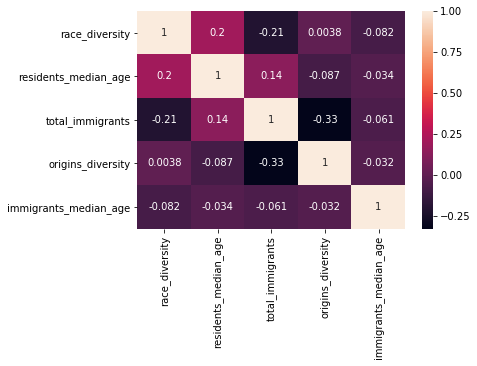

In [70]:
import seaborn as sns
%matplotlib inline
sns.heatmap(corr_df, annot=True)

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.